In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# getting access to data_prep.py functions inside flood_prediction package
import sys
sys.path.append('../')
sys.path.append('../flood_prediction')
from flood_prediction.ml_logic.data_prep import *

# Getting raw data

In [8]:
df = get_data_and_targets()
df.head()

,date,T(degC),rain(mm),surf_press(hPa),wind_s(km/h),wind_dir(deg),soil_moist_0_to_7cm(m3),soil_moist_7_to_28cm(m3),radiation(W/m2),river_discharge(m3/s),target
0,1984-01-01 00:00:00,19.2,0.0,982.1,4.5,331.0,0.251,0.278,0.0,48.77,0
1,1984-01-01 01:00:00,19.1,0.0,981.9,4.5,331.0,0.251,0.278,0.0,48.77,0
2,1984-01-01 02:00:00,18.6,0.0,982.0,4.1,345.0,0.251,0.278,0.0,48.77,0
3,1984-01-01 03:00:00,18.2,0.0,981.9,3.6,6.0,0.251,0.278,0.0,48.77,0
4,1984-01-01 04:00:00,17.7,0.0,981.9,3.7,11.0,0.251,0.278,0.0,48.77,0


# Feature Engineering

### Dealing with soil moisture

In [9]:
# We'll sum soil_moist_0_to_7cm(m3) and soil_moist_7_to_28cm(m3) to get soil_moist_0_to_28cm(m3)
df['soil_moist_0_to_28cm(m3)'] = ((df['soil_moist_0_to_7cm(m3)'] + df['soil_moist_7_to_28cm(m3)']) / 2)
df.drop(['soil_moist_0_to_7cm(m3)', 'soil_moist_7_to_28cm(m3)'], axis=1, inplace=True)

In [10]:
df.head()

,date,T(degC),rain(mm),surf_press(hPa),wind_s(km/h),wind_dir(deg),radiation(W/m2),river_discharge(m3/s),target,soil_moist_0_to_28cm(m3)
0,1984-01-01 00:00:00,19.2,0.0,982.1,4.5,331.0,0.0,48.77,0,0.2645
1,1984-01-01 01:00:00,19.1,0.0,981.9,4.5,331.0,0.0,48.77,0,0.2645
2,1984-01-01 02:00:00,18.6,0.0,982.0,4.1,345.0,0.0,48.77,0,0.2645
3,1984-01-01 03:00:00,18.2,0.0,981.9,3.6,6.0,0.0,48.77,0,0.2645
4,1984-01-01 04:00:00,17.7,0.0,981.9,3.7,11.0,0.0,48.77,0,0.2645


### Dealing with wind direction and wind speed

--------------------------------------------------
Working with angles...


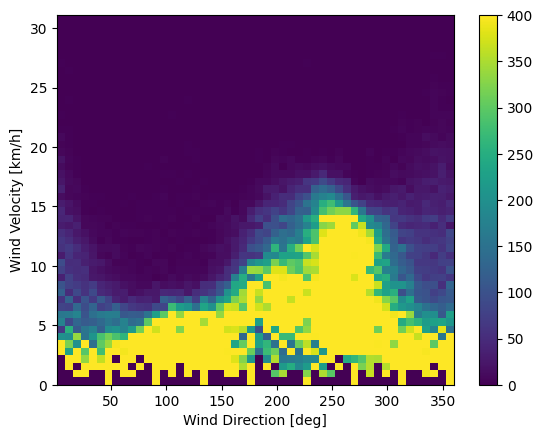

--------------------------------------------------
Working with wind vectors


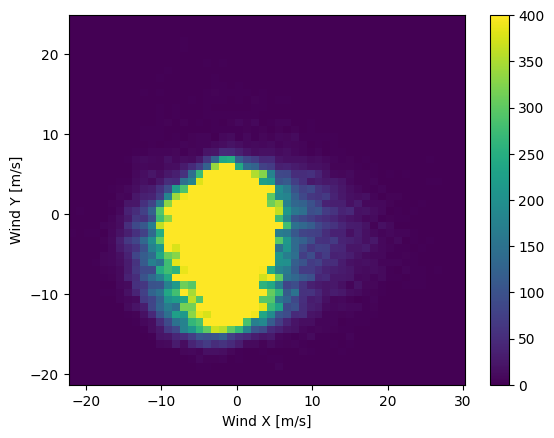

In [11]:
# wind_dir(deg) : degrees from 0 to 360 egrees
# Angles do not make good models inputs because 0 and 360 should be "close"

print('-'*50)
print("Working with angles...")

plt.hist2d(df['wind_dir(deg)'], df['wind_s(km/h)'], 
           bins=(50, 50), 
           vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [km/h]')
plt.show()

# It is much easier for the model to interpret
# the wind direction and the wind velocity through a vector
# Convert degrees to radians and store the values into wd_rad
wd_rad = df.pop('wind_dir(deg)')*np.pi / 180

# Calculate the wind x and y components and store then in two new columns
# `Wx` and `Wy`
wv = df.pop('wind_s(km/h)')
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

print('-'*50)
print("Working with wind vectors")

plt.hist2d(df['Wx'], df['Wy'], 
           bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')
plt.show()

### Dealing with date and time

In [12]:
# Similarly to the wind direction, the time in seconds is not a useful model input
# The weather dataset has clear daily and yearly periodicities
# Using sine and cosine functions, we can compute:
# - the time of the day
# - the time of the year

# Collecting the timestamps
datetime_df = pd.to_datetime(df.pop('date'), format='%Y-%m-%d %H:%M:%S')
timestamps_s =  datetime_df.map(pd.Timestamp.timestamp)
timestamps_s

# 24 hours x 60 minutes/hour x 60 seconds/minute
day = 24*60*60 

# 1 month in days
month = (365.2425/12)*day

# 1 year in days
year = (365.2425)*day

# Day periodicity
df['day_sin'] = np.sin(timestamps_s * (2 * np.pi / day))
df['day_cos'] = np.cos(timestamps_s * (2 * np.pi / day))

# Month periodicity
df['month_sin'] = np.sin(timestamps_s * (2 * np.pi / month))
df['month_cos'] = np.cos(timestamps_s * (2 * np.pi / month))

# Year periodicity
df['year_sin'] = np.sin(timestamps_s * (2 * np.pi / year))
df['year_cos'] = np.cos(timestamps_s * (2 * np.pi / year))

In [13]:
df.head()

,T(degC),rain(mm),surf_press(hPa),radiation(W/m2),river_discharge(m3/s),target,soil_moist_0_to_28cm(m3),Wx,Wy,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos
0,19.2,0.0,982.1,0.0,48.77,0,0.2645,3.935789,-2.181643,-2.239978e-12,1.000000,-0.081451,0.996677,-0.006795,0.999977
1,19.1,0.0,981.9,0.0,48.77,0,0.2645,3.935789,-2.181643,2.588190e-01,0.965926,-0.072875,0.997341,-0.006078,0.999982
2,18.6,0.0,982.0,0.0,48.77,0,0.2645,3.960296,-1.061158,5.000000e-01,0.866025,-0.064294,0.997931,-0.005362,0.999986
3,18.2,0.0,981.9,0.0,48.77,0,0.2645,3.580279,0.376302,7.071068e-01,0.707107,-0.055708,0.998447,-0.004645,0.999989
4,17.7,0.0,981.9,0.0,48.77,0,0.2645,3.632021,0.705993,8.660254e-01,0.500000,-0.047118,0.998889,-0.003928,0.999992
